In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# Define years that we're interested in
years = list(range(2010,2020))

#Create an empty Dataframe that we'll be using to combine yearly stats
df = pd.DataFrame()

#Iterate through list of years
for year in years:
    
    #Read in each year's .csv file
    filename = str(year) + ".csv"
    year_df = pd.read_csv(filename,index_col=0)
    
    #Add a Year column and a Points Per Game column
    year_df['Season'] = year
    year_df['PPG'] = year_df['FantasyPoints'] / year_df['G']
    
    #Remove Players with Position "0" and Set Min. Games Played to 8
    year_df = year_df[(year_df['Pos'] != '0') & (year_df['G'] >= 8)]
    
    #Append this year's stats to df
    df = df.append(year_df[['Season','Player','Tm','Pos','G','FantasyPoints','PPG']],ignore_index=True)

In [3]:
# Define a function to assign each player a tier based on Z-Score
def createTier(z):
    
    if z >= 3:
        tier = "Elite"
    elif (z < 3) & (z >= 2):
        tier = "Excellent"
    elif (z < 2) & (z >= 1):
        tier = "Great"
    elif (z < 1) & (z >= .5):
        tier = "Above Average"
    elif (z < .5) & (z >= -.5):
        tier = "Average"
    elif (z < -.5) & (z >= -1):
        tier = "Below Average"
    elif (z < -1) & (z >= -2): 
        tier = "Bad"
    else:
        tier = "Horrible"
        
    return tier

# Define a function to show positional tier (ex. top 10 RBs are all RB1 in 10 Team)
def positionTiers(teams,pos,posRank):
    
    if posRank <= teams:
        posTier = pos + "1"
    elif (posRank > teams) & (posRank <= 2*teams):
        posTier = pos + "2"
    elif (posRank > 2*teams) & (posRank <= 3*teams):
        posTier = pos + "3"
    elif (posRank > 3*teams) & (posRank <= 4*teams):
        posTier = pos + "4"
    else:
        posTier = pos + "5"
        
    return posTier

In [4]:
# Iterate through the years previously defined
for year in years:
    
    # For each position/year, get the Mean and Standard Deviation of PPG
    
    # Iterate through each unique position
    for pos in list(df['Pos'].unique()):
        
        if pos == 'QB':
            size = 10
        elif ((pos == 'RB') | (pos == 'WR')):
            size = 30
        elif (pos == 'TE'):
            size = 20
        
        # Create a temporary copy of df filtered by year/position and sorted by PPG
        df1 = df[(df['Season'] == year ) & (df['Pos'] == pos)].sort_values(by='PPG',ascending=False)
        
        # Initial ranking per year/position
        rank = 1
        
        # Iterate through players in df1
        for i,player in df1.iterrows():
            
            # Assign Pos. Ranking, Pos. Tier, Z-Score and Tier.
            df.loc[i,'Pos Rank'] = rank
            df.loc[i,'Pos Tier'] = positionTiers(10,player['Pos'],rank)

            # Add 1 to rank for each row
            rank += 1
        
        # Calculate Mean and Standard Deviation for Position in given Season
        mean = np.mean(df[(df['Pos'] == pos) & (df['Pos Rank'] <= size) & (df['Season'] == year)]['PPG'])
        std = np.std(df[(df['Pos'] == pos) & (df['Pos Rank'] <= size) & (df['Season'] == year)]['PPG'])
        
        # Iterate through players in df1 again
        for i,player in df1.iterrows():
            
            # Assign Z-Score and Tier to each player (relative to season)
            df.loc[i,'Z'] = (player['PPG'] - mean) / std
            df.loc[i,'Tier'] = createTier((player['PPG'] - mean) / std)

# Filter the new Dataframe by Position and Position Rank
df = df[((df['Pos'] == 'QB') & (df['Pos Rank'] <= 10)) |
        ((df['Pos'] == 'RB') & (df['Pos Rank'] <= 30)) |
        ((df['Pos'] == 'WR') & (df['Pos Rank'] <= 30)) |
        ((df['Pos'] == 'TE') & (df['Pos Rank'] <= 20))].reset_index(drop=True).copy()

In [5]:
# Top 15 Z-Scores since 2010
df.sort_values(by='Z',ascending=False).head(15)

,Season,Player,Tm,Pos,G,FantasyPoints,PPG,Pos Rank,Pos Tier,Z,Tier
816,2019,Michael Thomas,NOR,WR,16.0,374.60,23.412500,1.0,WR1,3.755476,Elite
810,2019,Christian McCaffrey,CAR,RB,16.0,469.20,29.325000,1.0,RB1,3.631911,Elite
451,2015,Devonta Freeman,ATL,RB,15.0,316.40,21.093333,1.0,RB1,3.249927,Elite
35,2010,Antonio Gates,SDG,TE,10.0,188.20,18.820000,1.0,TE1,3.213957,Elite
636,2017,Antonio Brown,PIT,WR,14.0,308.30,22.021429,1.0,WR1,3.107731,Elite
270,2013,Jamaal Charles,KAN,RB,15.0,378.00,25.200000,1.0,RB1,3.046684,Elite
93,2011,Calvin Johnson,DET,WR,16.0,359.20,22.450000,1.0,WR1,2.961803,Excellent
0,2010,Arian Foster,HOU,RB,16.0,392.00,24.500000,1.0,RB1,2.815254,Excellent
630,2017,Todd Gurley,LAR,RB,15.0,383.30,25.553333,1.0,RB1,2.788490,Excellent
545,2016,Le'Veon Bell,PIT,RB,12.0,315.40,26.283333,1.0,RB1,2.784819,Excellent


In [6]:
# QB1s sorted by PPG for 2019
df[(df['Pos'] == 'QB') & (df['Season'] == 2019)].sort_values(by='PPG',ascending=False)

,Season,Player,Tm,Pos,G,FantasyPoints,PPG,Pos Rank,Pos Tier,Z,Tier
811,2019,Lamar Jackson,BAL,QB,15.0,415.68,27.712000,1.0,QB1,2.694311,Excellent
826,2019,Deshaun Watson,HOU,QB,15.0,318.98,21.265333,2.0,QB1,0.225038,Average
821,2019,Dak Prescott,DAL,QB,16.0,335.78,20.986250,3.0,QB1,0.118140,Average
880,2019,Matthew Stafford,DET,QB,8.0,166.56,20.820000,4.0,QB1,0.054461,Average
878,2019,Drew Brees,NOR,QB,11.0,224.76,20.432727,5.0,QB1,-0.093876,Average
823,2019,Russell Wilson,SEA,QB,16.0,326.60,20.412500,6.0,QB1,-0.101624,Average
856,2019,Patrick Mahomes,KAN,QB,14.0,285.04,20.360000,7.0,QB1,-0.121733,Average
839,2019,Jameis Winston,TAM,QB,16.0,297.36,18.585000,8.0,QB1,-0.801613,Below Average
879,2019,Ryan Tannehill,TEN,QB,12.0,222.18,18.515000,9.0,QB1,-0.828425,Below Average
873,2019,Matt Ryan,ATL,QB,15.0,265.34,17.689333,10.0,QB1,-1.144681,Bad


In [7]:
# Generate Summary table by Position
summary1 = df.groupby(by='Pos')['PPG'].describe()

# PPG Range
summary1['Range'] = summary1['max'] - summary1['min']

# PPG Interquartile Range
summary1['IQR'] = summary1['75%'] - summary1['25%']

# PPG Mild and Extreme Outliers
summary1['mOutlier'] = summary1['75%'] + (1.5 * summary1['IQR'])
summary1['eOutlier'] = summary1['75%'] + (3 * summary1['IQR'])

for i,pos in summary1.iterrows():
    
    summary1.loc[i,'mOutlier Count'] = len(df[(df['Pos'] == i) & (df['PPG'] > pos['mOutlier'])])
    summary1.loc[i,'eOutlier Count'] = len(df[(df['Pos'] == i) & (df['PPG'] > pos['eOutlier'])])

In [8]:
summary1

,count,mean,std,min,25%,50%,75%,max,Range,IQR,mOutlier,eOutlier,mOutlier Count,eOutlier Count
Pos,,,,,,,,,,,,,,
QB,100.0,19.636980,2.447472,15.804286,17.677357,19.209196,21.026418,27.712000,11.907714,3.349061,26.050010,31.073602,2.0,0.0
RB,300.0,14.717634,3.734858,9.680000,11.918437,13.962500,16.700357,29.325000,19.645000,4.781920,23.873237,31.046116,9.0,0.0
TE,200.0,11.019478,2.798581,6.463636,8.920000,10.478125,12.766146,20.681250,14.217614,3.846146,18.535365,24.304583,2.0,0.0
WR,300.0,15.738635,2.708322,11.622667,13.698214,15.213333,17.393750,24.583333,12.960667,3.695536,22.937054,28.480357,5.0,0.0


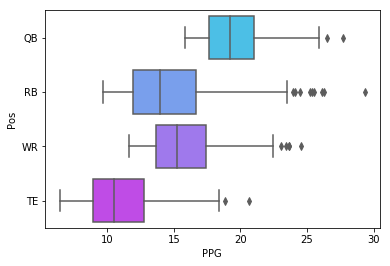

In [9]:
# Generate Boxplot of 2015-2019 Positional Scoring
sns.boxplot(x='PPG',
            y='Pos',
            data=df,
            order=['QB','RB','WR','TE'],
            palette='cool')

In [10]:
# Generate Z-Score Summary table by Position
summary2 = df.groupby(by='Pos')['Z'].describe()

# Z-Score Range
summary2['Range'] = summary2['max'] - summary2['min']

In [11]:
summary2

,count,mean,std,min,25%,50%,75%,max,Range
Pos,,,,,,,,,
QB,100.0,-2.124689e-16,1.005038,-1.361124,-0.816941,-0.221991,0.618706,2.717098,4.078223
RB,300.0,6.587323e-17,1.001671,-1.438162,-0.786193,-0.260399,0.598480,3.631911,5.070073
TE,200.0,-2.442491e-17,1.002509,-1.523373,-0.800984,-0.260846,0.618016,3.213957,4.737330
WR,300.0,-1.617225e-16,1.001671,-1.636534,-0.818052,-0.178483,0.659077,3.755476,5.392011


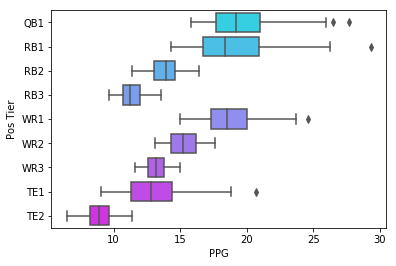

In [12]:
# Generate Boxplot of 2015-2019 Positional Scoring
plt.figure
sns.boxplot(x='PPG',
            y='Pos Tier',
            data=df,
            order=['QB1','RB1','RB2','RB3','WR1','WR2','WR3','TE1','TE2'],
            palette='cool')